## Predicting Commodity Prices Using Kalman Filter Algorithms: The case of Coffee and Sesame


### What is Kalman Filter?

The Kalman filter is an algorithm that uses noisy observations of a system over time to estimate the parameters of the system  and predict future observations. Note that some of systems are unobservable. At each time step, it makes a prediction, takes in a measurement, and updates itself based on how the prediction and measurement compare.

The algorithm is as follows:

Take as input a mathematical model of the system, i.e.
the transition matrix, which tells us how the system evolves from one state to another. For instance, if we are modeling the movement of a car, then the next values of position and velocity can be computed from the previous ones using kinematic equations. Alternatively, if we have a system which is fairly stable, we might model its evolution as a random walk. If you want to read up on Kalman filters, note that this matrix is usually called $A$.
the observation matrix, which tells us the next measurement we should expect given the predicted next state. If we are measuring the position of the car, we just extract the position values stored in the state. For a more complex example, consider estimating a linear regression model for the data. Then our state is the coefficients of the model, and we can predict the next measurement from the linear equation. This is denoted $H$.
any control factors that affect the state transitions but are not part of the measurements. For instance, if our car were falling, gravity would be a control factor. If the noise does not have mean 0, it should be shifted over and the offset put into the control factors. The control factors are summarized in a matrix $B$ with time-varying control vector $u_t$, which give the offset $Bu_t$.
covariance matrices of the transition noise (i.e. noise in the evolution of the system) and measurement noise, denoted $Q$ and $R$, respectively.
Take as input an initial estimate of the state of the system and the error of the estimate, $\mu_0$ and $\sigma_0$.
At each timestep:
estimate the current state of the system $x_t$ using the transition matrix
take as input new measurements $z_t$
use the conditional probability of the measurements given the state, taking into account the uncertainties of the measurement and the state estimate, to update the estimated current state of the system $x_t$ and the covariance matrix of the estimate $P_t$
This graphic illustrates the procedure followed by the algorithm.

It's very important for the algorithm to keep track of the covariances of its estimates. This way, it can give us a more nuanced result than simply a point value when we ask for it, and it can use its confidence to decide how much to be influenced by new measurements during the update process. The more certain it is of its estimate of the state, the more skeptical it will be of measurements that disagree with the state.

By default, the errors are assumed to be normally distributed, and this assumption allows the algorithm to calculate precise confidence intervals. It can, however, be implemented for non-normal errors.

<details><summary> Why the price of coffee matters the economy of the growing countries?</summary>
    Coffee price is highly fluctuated and has significant effect on the economy and conducting a regirous research on forecasting coffee price has theoretical and practical importance. This study aims at forecasting the coffee price in Ethiopia. We used daily closed price data of Ethiopian coffee recorded in the period 25 June 2008 to 5 January 2017 obtained from Ethiopia commodity exchange (ECX) market to analyse coffee prices fluctuation. Here, the nature of coffee price is non-stationary and we apply the Kalman filtering algorithm on a single linear state space model to estimate and forecast an optimal value of coffee price. 

### Importing Useful Libraries

In [2]:
## Importing libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from bokeh.plotting import figure, show, output_notebook
#from datetime import date
from pykalman import KalmanFilter
import seaborn as sns
#from nsepy.archives import get_price_history

#plt.style.use('fivethirtyeight')

plt.style.use('ggplot')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'


### Example 1: Predicting Ethiopian Coffee Prices Using Kalman Filter Algorithms


Coffee is one of such agricultural products which play a vital role in the Ethiopia economy. Ethiopia is known as the birth place of Coffee Arabica. Coffee dominates export revenues in Ethiopia, such a pattern will not change in the short period of time.

Global coffee production varies from year to year according to weather conditions, disease and other factors,
resulting in a coffee market that is inherently unstable and characterized by wide fluctuations in price. This price volatility has significant consequences for those who depend on coffee for their livelihood, making it difficult for growers to predict their income for the coming season and budget for their household and farming needs. Ethiopian coffee prices are often varies as they are largely influenced by production, demand of coffee in domestic and world level forces, quality of product etc. So, conducting research on coffee price forecasting is very important to reduce a risk associated price fluctuation. 



### Load the data

In [3]:
#Loading the data

data=pd.read_csv('COFFEE.csv')
df=pd.DataFrame(data,columns=['Close','Date','High','Low','Open','Volume'])

#set the date as index

df['Date']=pd.to_datetime(df['Date'])
df.index=df['Date']

df = df.drop(columns = 'Date')

### Displaying the first five rows of the dataframe

In [4]:
# Dispalying the data
df.head()

,Close,High,Low,Open,Volume
Date,,,,,
2017-01-05,20.540001,20.799999,20.340000,20.340000,179900
2017-01-04,20.209999,20.320000,20.059999,20.100000,276800
2017-01-03,19.610001,19.650000,19.020000,19.379999,290900
2016-12-30,19.559999,19.730000,19.340000,19.600000,225600
2016-12-29,19.290001,19.660000,18.980000,19.000000,283800


In [5]:
df.shape #we have 2149 rows and 7 culumn data

(2149, 5)

## Checking missing values

In [6]:
df.isnull().sum()

Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64

In [7]:
old_columns = ['Close','High','Low','Open','Volume']

new_columns = [col.lower() for col in old_columns]
new_columns

['close', 'high', 'low', 'open', 'volume']

### Renaming the column names into lower cases

In [9]:
df.columns = new_columns
df.head()

,close,high,low,open,volume
Date,,,,,
2017-01-05,20.540001,20.799999,20.340000,20.340000,179900
2017-01-04,20.209999,20.320000,20.059999,20.100000,276800
2017-01-03,19.610001,19.650000,19.020000,19.379999,290900
2016-12-30,19.559999,19.730000,19.340000,19.600000,225600
2016-12-29,19.290001,19.660000,18.980000,19.000000,283800


## EDA: 
**See the relationship between variables among themselves with heat map**

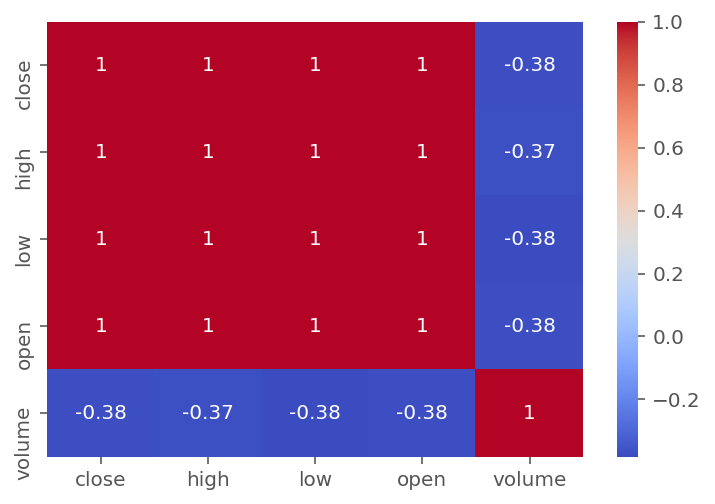

In [10]:
sns.heatmap(df.corr(),
            annot = True,
            cmap='coolwarm'
           )

**All the variables are highly correlated  to each other, but the voluume.**

### Visualising the Closing Prices of Coffee

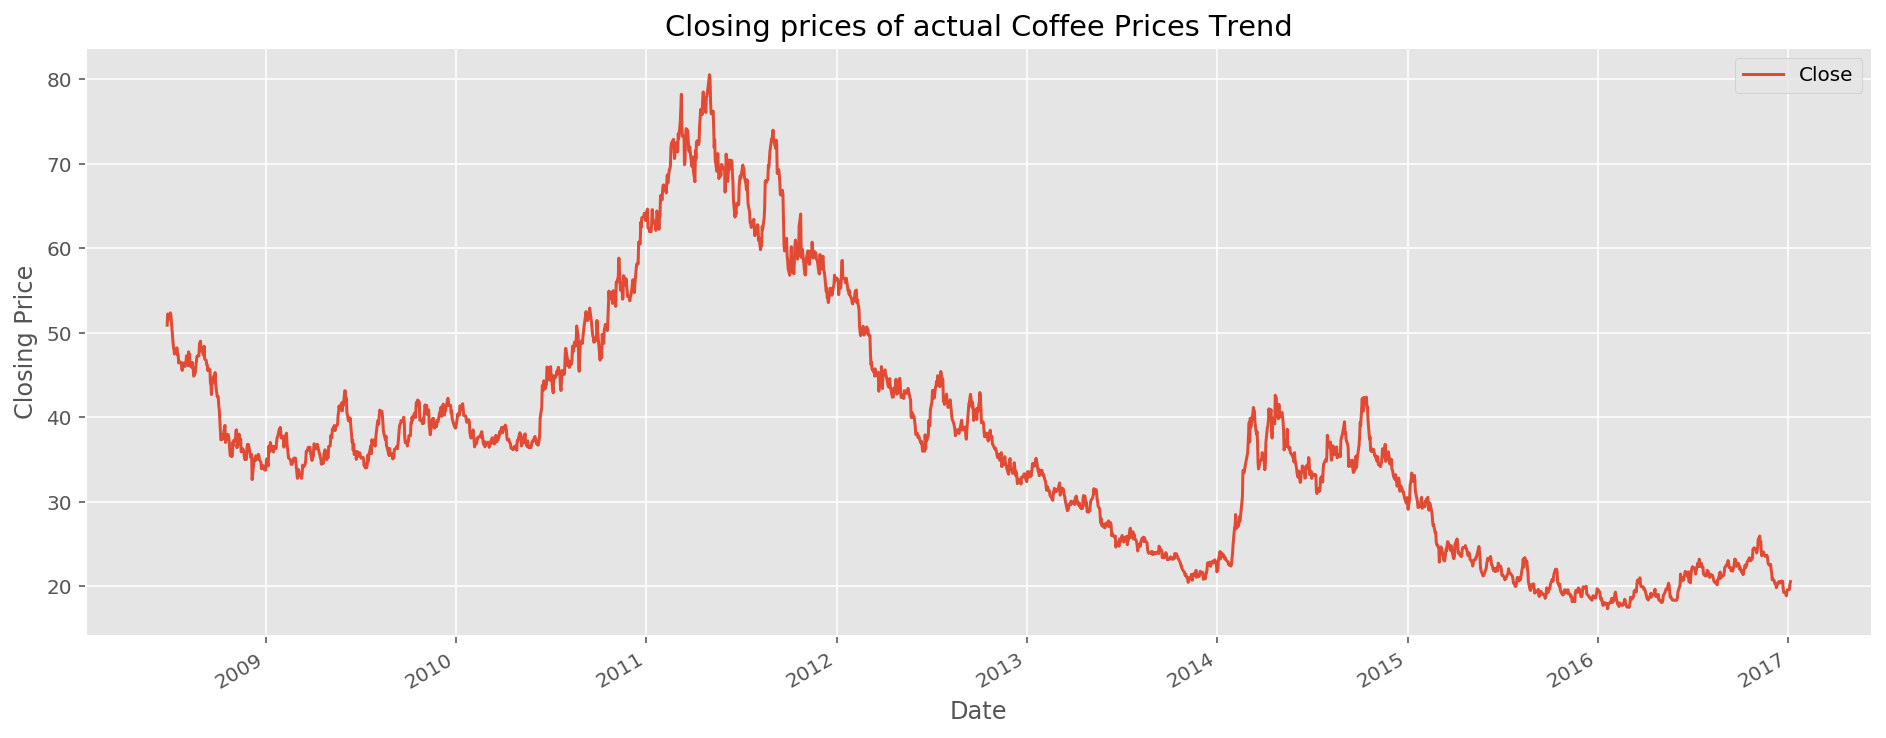

In [11]:
# Ploting the closing prices of coffee:(A time series data) that can also be visualize like this.
df["close"].plot(
    figsize=(16,6),
    label = 'Close')
plt.ylabel('Closing Price')
plt.legend()
plt.title('Closing prices of actual Coffee Prices Trend')
plt.show()

Text(0, 0.5, 'Volume')

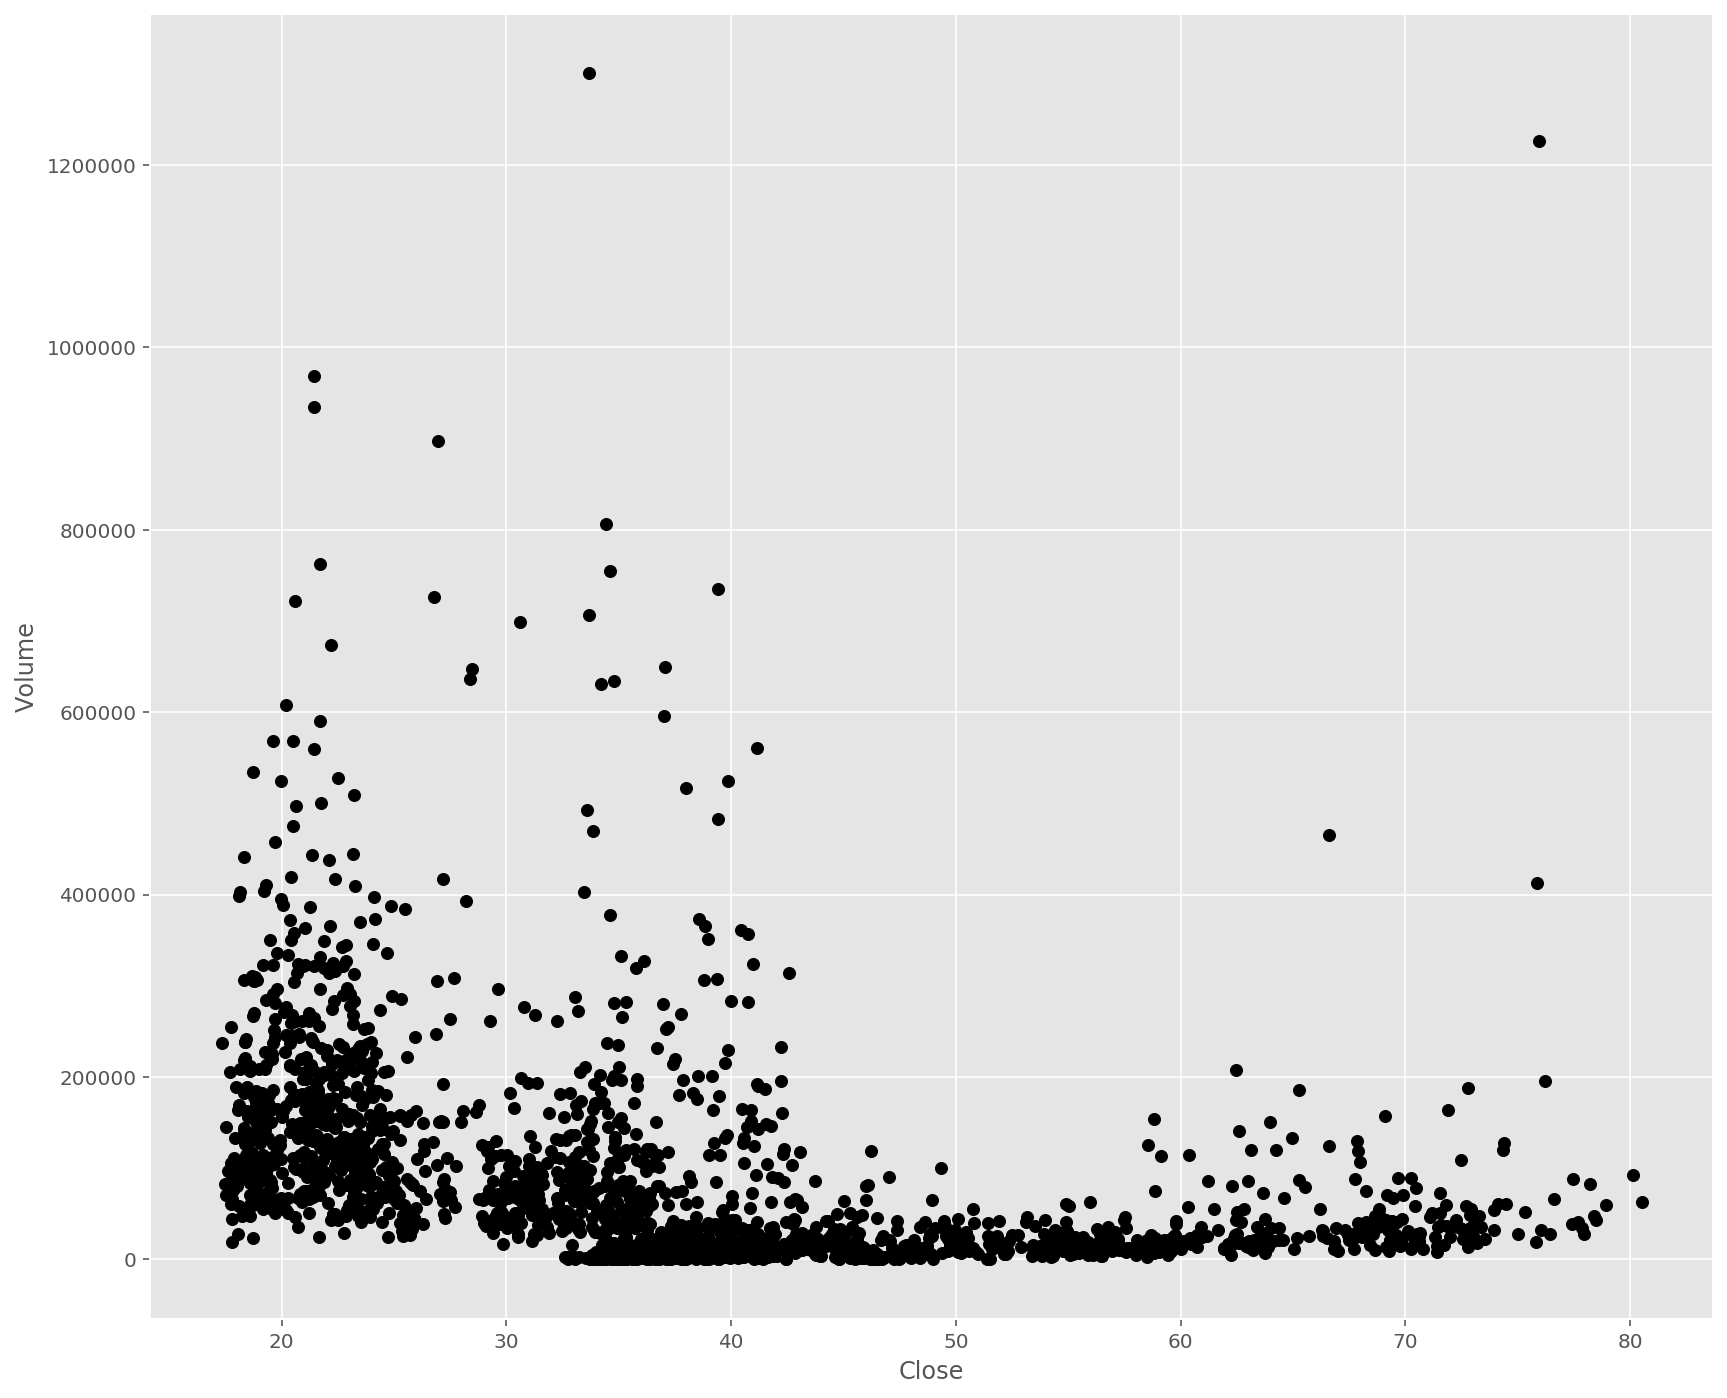

In [14]:
plt.figure(figsize = (14,12))
plt.scatter(df['close'],
            df['volume'],
            color = 'black')
plt.xlabel('Close')
plt.ylabel('Volume')

In [11]:
#df['close']

Text(0.5, 0, 'Close')

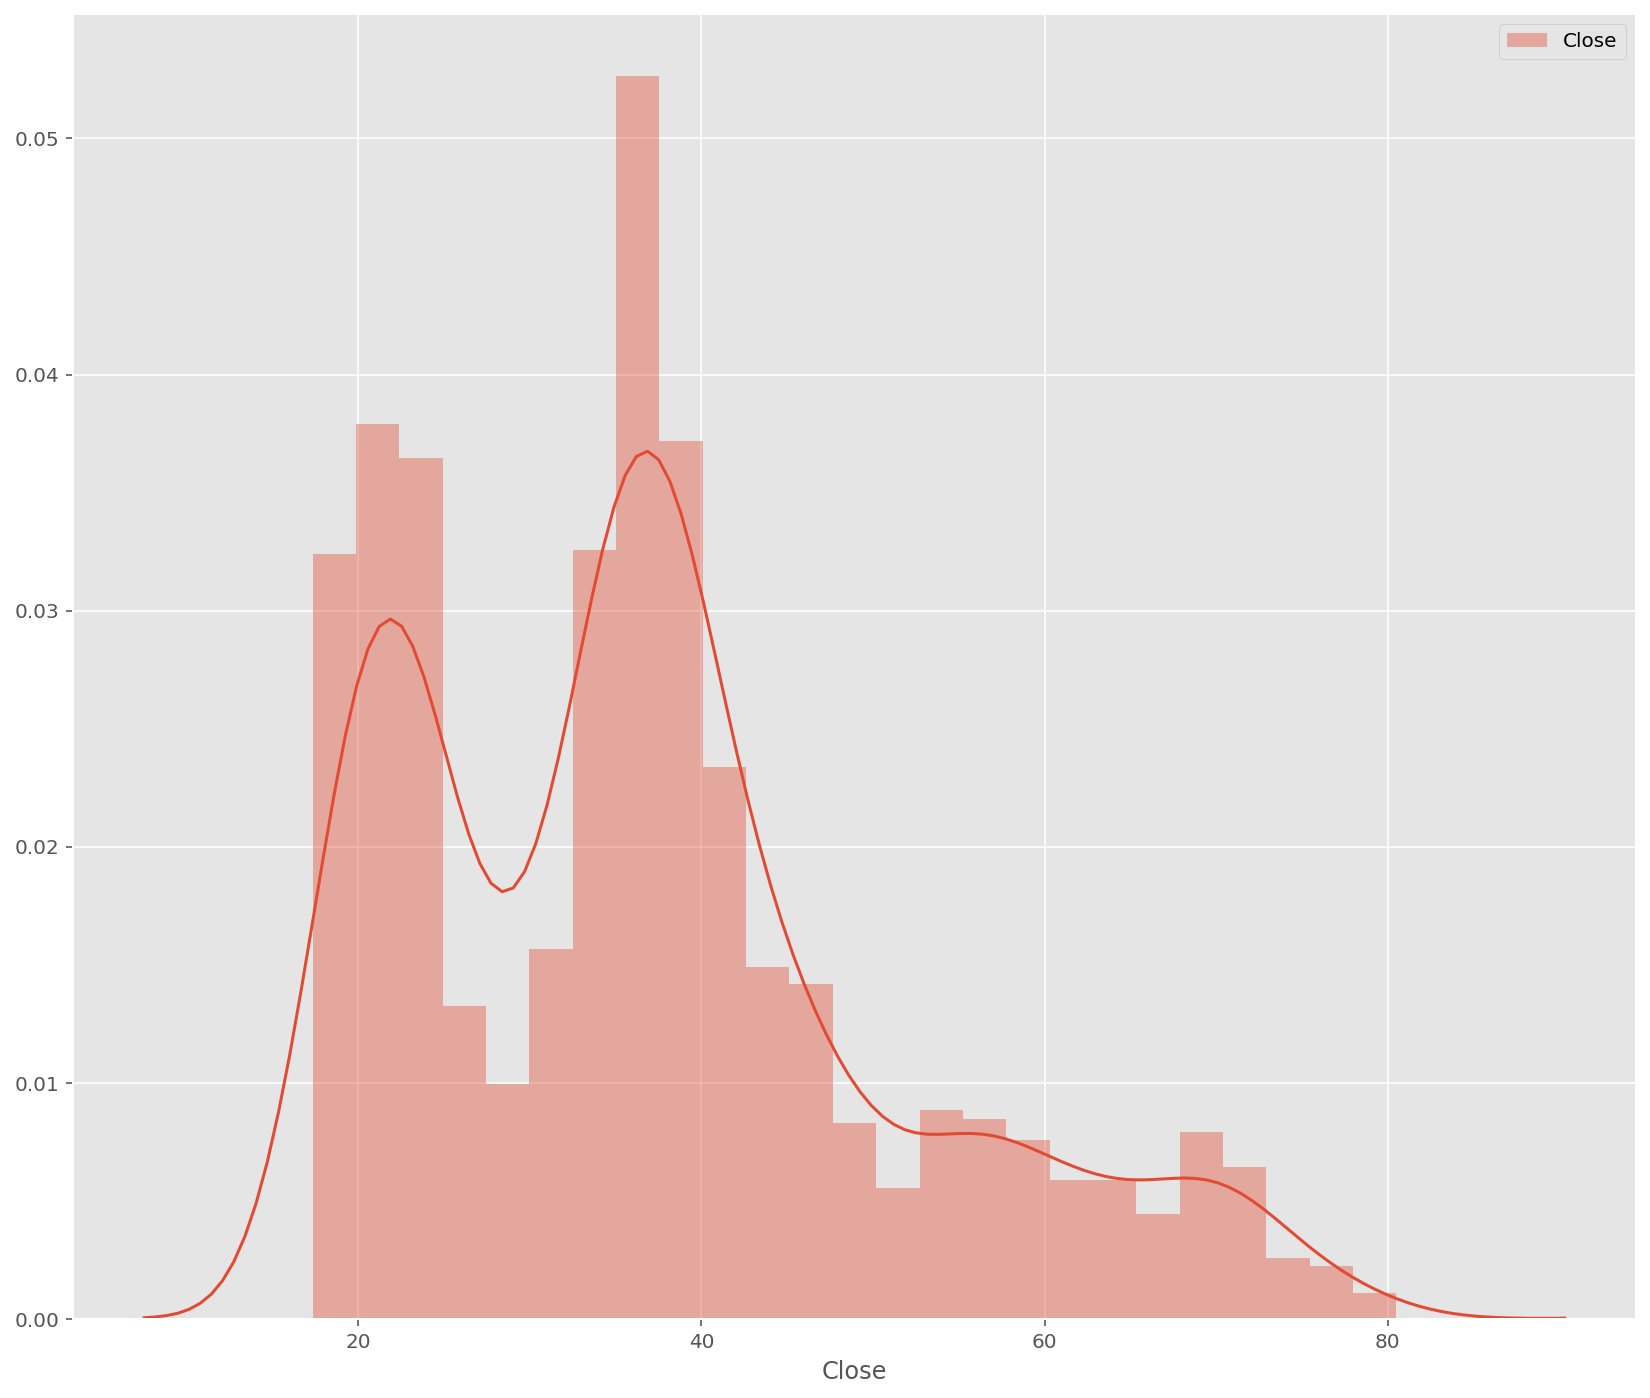

In [15]:
plt.figure(figsize = (14,12))
sns.distplot(df['close'],
            bins =25,
            label = 'Close')
plt.legend()
plt.xlabel('Close')




#### Applying  Kalman Filtering Algorithm to Predict the  Close Price of Coffee on Commodity Exchanges

In [16]:
from pykalman import KalmanFilter
kf = KalmanFilter(transition_matrices = [1],
                  observation_matrices = [1],
                  initial_state_mean = df['close'].values[0],
                  initial_state_covariance = 1,
                  observation_covariance=1,
                  transition_covariance=.01)

In [17]:
state_means,_ = kf.filter(df[['close']].values)
state_means = pd.Series(state_means.flatten(), index=df.index)#state_means.flatten()

In [18]:
df['close'].values.mean()

37.17646813401581

In [19]:
#Defining the Mean Square Error

def RMSE(y,y_hat):
    difference = y-y_hat
    difference_square = difference**2
    mean_squared_difference = np.mean(difference_square)
    root_mean_squared_difference = np.sqrt(mean_squared_difference)
    return root_mean_squared_difference

In [20]:
 RMSE(df['close'], state_means)

1.7273988030311151

In [23]:
df["Date"] = pd.to_datetime(df.index)

mids = (df.open + df.close)/2
spans = abs(df.close-df.open)

inc = df.close > df.open
dec = df.open > df.close
w = 12*60*60*1000 # half day in ms

output_notebook()

TOOLS = "pan,wheel_zoom,box_zoom,reset,save"

p = figure(x_axis_type="datetime", tools=TOOLS, plot_width=1000, toolbar_location="left",y_axis_label = "Price",
          x_axis_label = "Date")

p.segment(df.Date, df.high, df.Date, df.low, color="black")
p.rect(df.Date[inc], mids[inc], w, spans[inc], fill_color='green', line_color="green")
p.rect(df.Date[dec], mids[dec], w, spans[dec], fill_color='red', line_color="red")
p.line(df.Date,state_means,line_width=1,line_color = 'blue',legend="Kalman filter")

#p.title("Implementation of Kalman Filter Estimation - TCS EOD chart")
p.xaxis.major_label_orientation = np.pi/4
p.grid.grid_line_alpha=0.3
plt.show()

Loading BokehJS ...

## Kalman Filtering Estimation Visualization

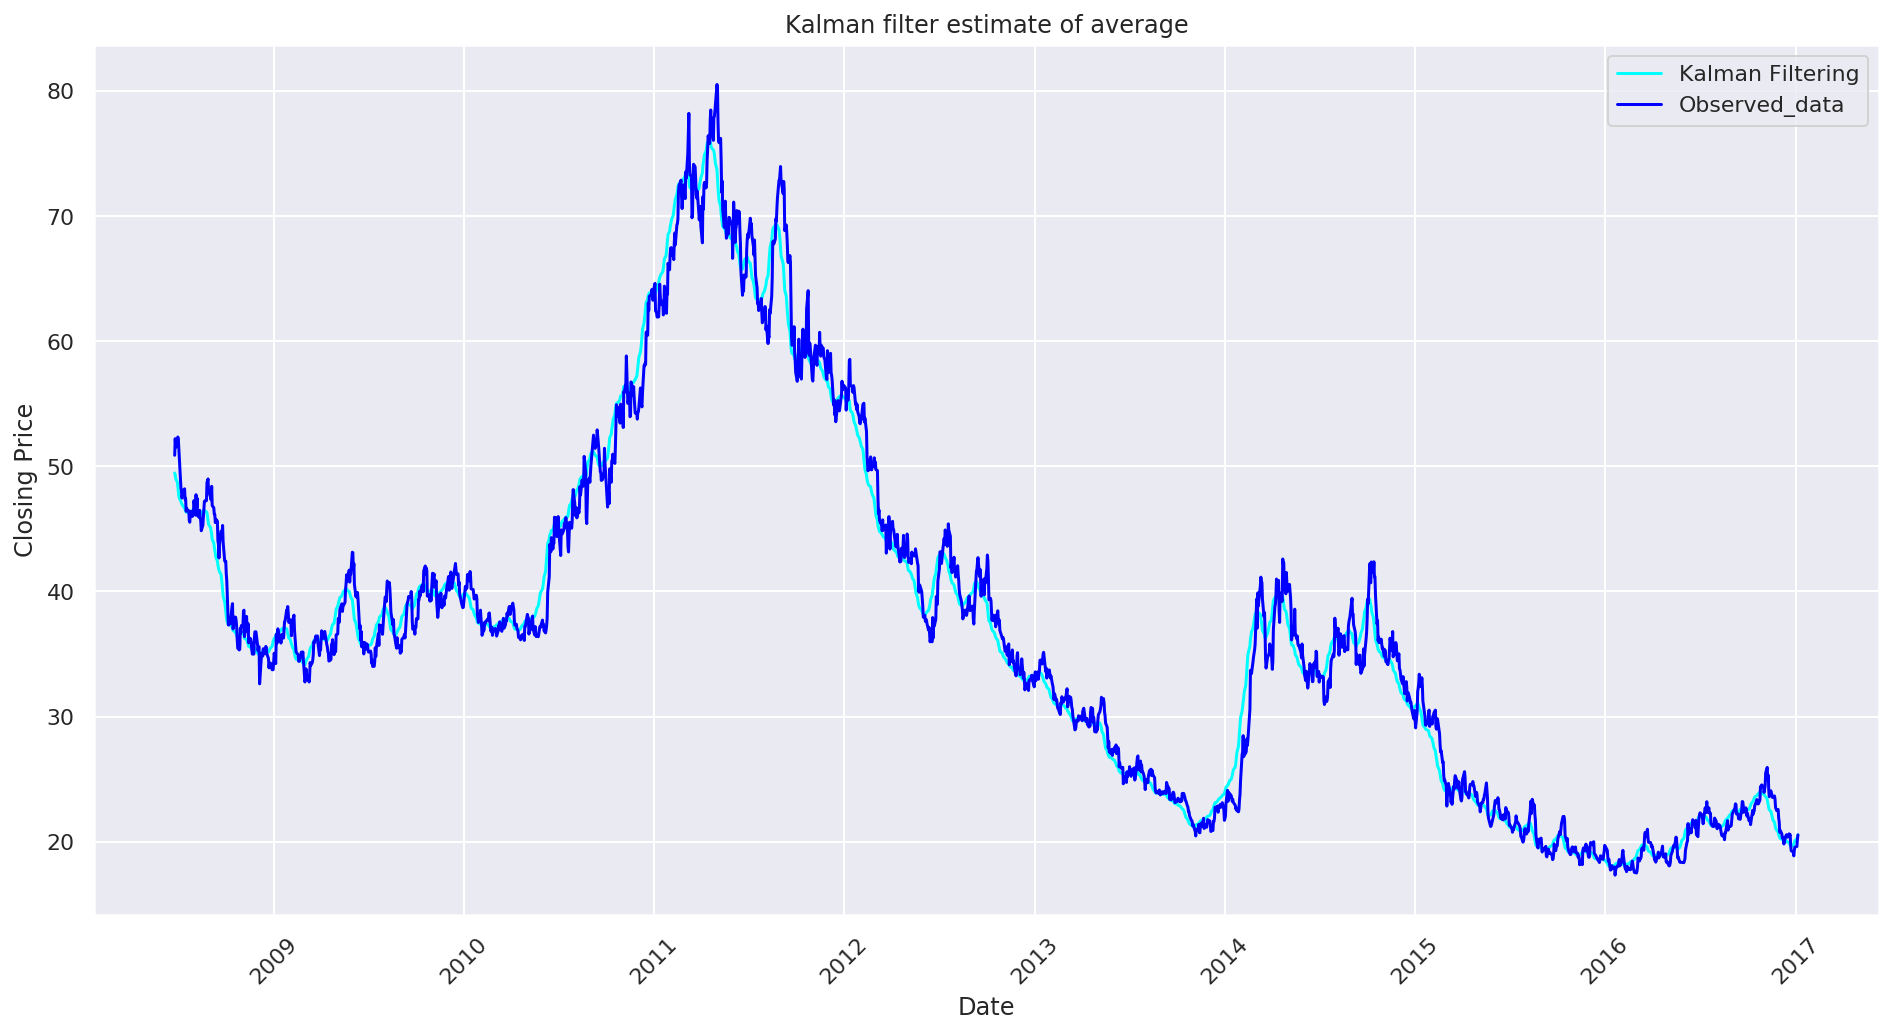

In [25]:
sns.set()
plt.figure(figsize=(16,8))
#colors = ['#2300A8', '#00A658']
plt.plot(df.Date,state_means,color='cyan')
plt.plot(df.Date,df["close"],color='blue')
plt.legend(['Kalman Filtering','Observed_data'])
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Kalman filter estimate of average')
plt.xticks(rotation = 45)
plt.show()

The performance of the algorithm for estimating and forecasting the coffee price is evaluated by using root mean square error (RMSE). Based on the linear state space model and the Kalman filtering algorithm, the root mean square error (RMSE) is 0.000016375, which is small enough, and it indicates that the algorithm performs well.

The Kalman Filter is a powerful tool for time series analysis and modeling, able to calculate difficult likelihoods of classical time series models and handle non-stationary models with exogenous control inputs.  Note that the free open-source implementation of the Kalman Filter makes sufficiently flexible for both statistical and engineering purposes, in statsmodels.

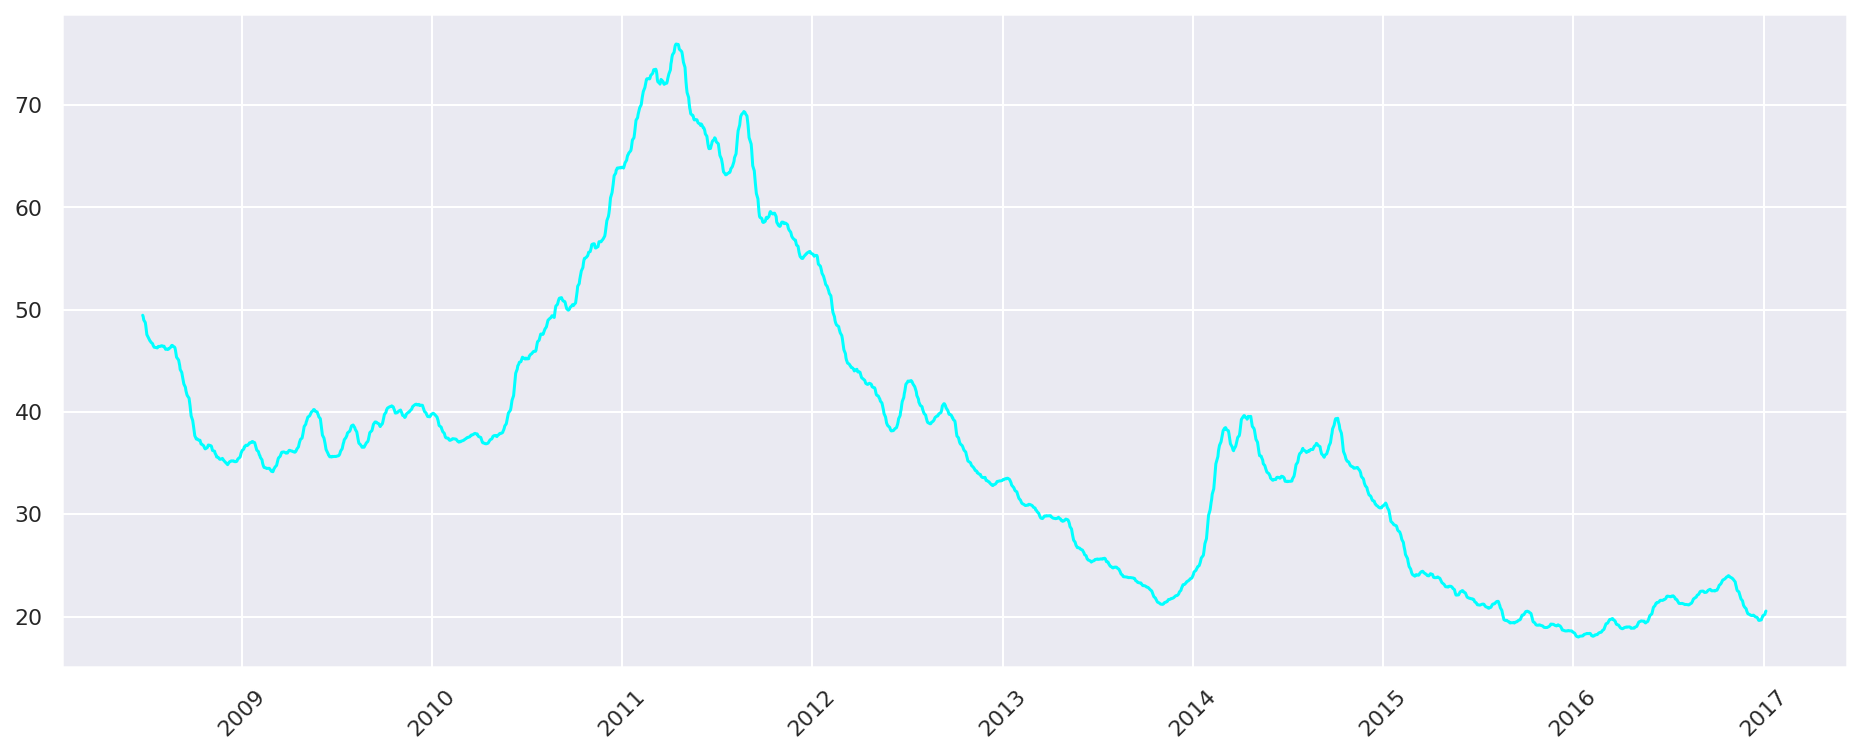

In [27]:
plt.figure(figsize = (16,6))
plt.plot(state_means, color ='cyan')
plt.xticks(rotation = 45)
plt.show()

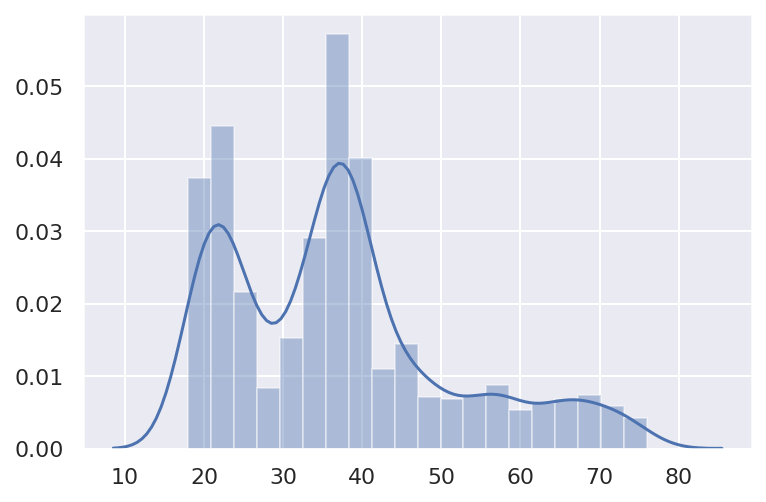

In [28]:
sns.distplot(state_means.values)